In [4]:
%matplotlib inline

import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#regexes for parsing the log files
def get_num_gpus(text):
    p = re.compile('\[batch = \d+ = \d+\*\d+\]')
    matches = p.findall(text)
    nums = re.findall(r'\d+',matches[0])
    return int(nums[-1])

def get_sync_percentages(text):
    p = re.compile('\[\d+.\d% calc., \d+.\d% synch.\]')
    matches = p.findall(text)[1:]
    nums = [float(re.findall(r'\d+.\d',match)[-1]) for match in matches]
    return np.mean(nums)/100
    
def get_loss(text):
    #p = re.compile('loss: \d+\.\d+ ')
    p = re.compile('loss: \d+\.\d+ \[\d+\.\d+\]')
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[-1]) for match in matches]
    return nums[-1]

def get_losses(text):
    p = re.compile('loss: \d+\.\d+ \[\d+\.\d+\]')
    #'loss: \d+\.\d+ \[\d+\.\d+\]'
    matches = p.findall(text)
    nums = [float(re.findall(r'\d+.\d+',match)[-1]) for match in matches]
    return np.array(nums)


#     return int(nums[-1])

def get_execution_time(text):
    p = re.compile('Epoch \d+.\d+ finished \(\d+.\d+ epochs passed\) in \d+.\d+ seconds')
    #p = re.compile('Epoch 2 finished in \d+.\d+ seconds')
    match = p.findall(text)[0]
    execution_time = float(re.findall(r'\d+\.\d',match)[-1])
    effective_epochs_passed = float(re.findall(r'\d+\.\d',match)[-2])
    return execution_time/effective_epochs_passed


def relative_array(arr):
    return arr/arr[0]

In [16]:
raw_path = './newtest/'
data_size = 'full' #'Titan' #full, large, medium
from os import listdir
from os.path import isfile, join
files = [join(raw_path,f) for f in listdir(raw_path) if (isfile(join(raw_path, f)) and data_size in f)]

In [17]:
import re
node_counts = [get_num_gpus(open(f).read()) for f in files]
print node_counts
files = list(zip(*sorted(zip(node_counts,files)))[1])
files
node_counts = np.array([get_num_gpus(open(f).read()) for f in files])
sync_percentages =np.array([get_sync_percentages(open(f).read()) for f in files] )
execution_times =np.array([get_execution_time(open(f).read()) for f in files])
losses = np.array([get_loss(open(f).read()) for f in files])
loss_arrays = [get_losses(open(f).read()) for f in files]

[24]


In [18]:
communication_work = sync_percentages/(1-sync_percentages)
scaled_execution_times = execution_times*node_counts
fictitious_node_counts = np.logspace(np.log10(2),np.log10(5000),100)
communication_work_extended = communication_work[-1]/np.log(node_counts[-1])*np.log(fictitious_node_counts)
#communication_work_extended_titan = 0.25*communication_work[-1]/np.log(node_counts[-1])*np.log(fictitious_node_counts)
modeled_execution_times = execution_times[0]*node_counts[0]/fictitious_node_counts*(1 + communication_work_extended)
#modeled_execution_times_titan = execution_times[0]*node_counts[0]/fictitious_node_counts*(1 + communication_work_extended_titan)
scaled_modeled_execution_times = fictitious_node_counts*modeled_execution_times


In [19]:
loss_arrays[-1]

array([ 1.04816,  0.50673,  0.23602,  0.17164,  0.044  ,  0.01846,
        0.02425,  0.07086,  0.09969,  0.08962,  0.07535,  0.06142,
        0.05591,  0.04328,  0.04155,  0.03081,  0.02032,  0.02561,
        0.02532,  0.0284 ,  0.02367,  0.02229,  0.03027,  0.03846,
        0.03265,  0.02961,  0.02874,  0.02642,  0.02517,  0.025  ,
        0.00921,  0.0066 ,  0.01082,  0.01557,  0.01925,  0.02301,
        0.02304,  0.02865,  0.02527,  0.02474,  0.0197 ,  0.02035,
        0.01216,  0.0123 ,  0.01153,  0.01047,  0.01168,  0.01081,
        0.00954,  0.01401,  0.0133 ,  0.01342,  0.01963,  0.02554,
        0.02259,  0.0245 ,  0.02127,  0.0151 ,  0.01591,  0.01684,
        0.00955,  0.00737,  0.00789,  0.00833,  0.0086 ,  0.00934,
        0.008  ,  0.01141,  0.01709,  0.02115,  0.01687,  0.01529,
        0.01554,  0.0189 ,  0.0201 ,  0.01489,  0.01229,  0.01499,
        0.0163 ,  0.01706,  0.01684,  0.01251,  0.01564,  0.01953,
        0.01224,  0.01   ,  0.01241,  0.02032,  0.02303,  0.02

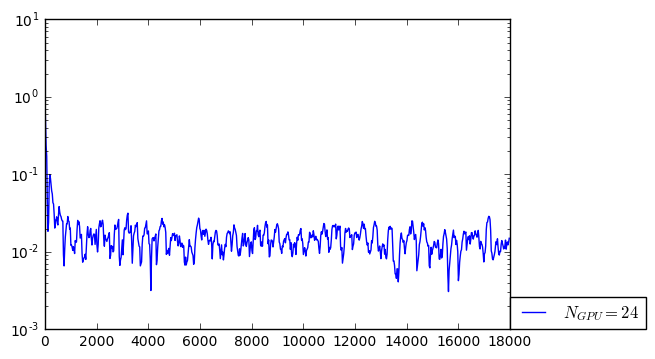

In [22]:
for (i,loss_arr) in enumerate(loss_arrays):
    plt.semilogy(np.array(range(len(loss_arr)))*node_counts[i],loss_arr,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
plt.legend(loc=(1,0))

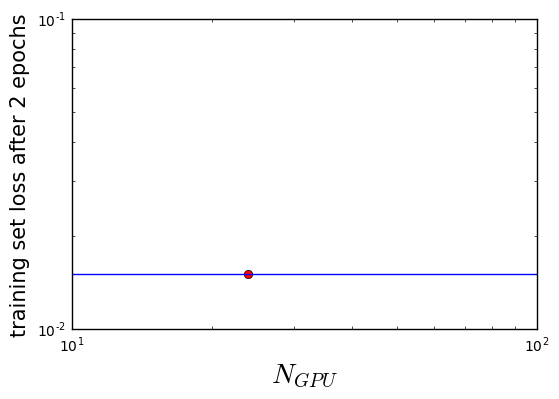

In [23]:
for (i,loss_arr) in enumerate(loss_arrays):
    plt.loglog(node_counts[i],loss_arr[-1],"or")#,label=r"$N_{{GPU}} = {{{}}}$".format(node_counts[i]))
plt.axhline(loss_arrays[0][-1])
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"training set loss after 2 epochs",size=15)
# plt.legend(loc=(1,0))

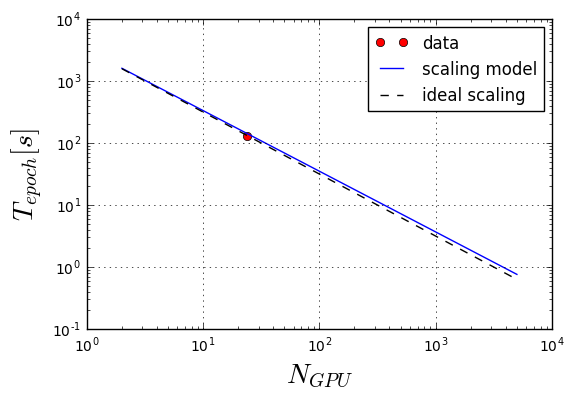

In [24]:
plt.loglog(node_counts,execution_times,'or',label="data")
plt.loglog(fictitious_node_counts,modeled_execution_times,label="scaling model")
#plt.loglog(fictitious_node_counts,modeled_execution_times_titan,label="scaling model 2")
plt.loglog(fictitious_node_counts,execution_times[0]*node_counts[0]/fictitious_node_counts,'--k',label="ideal scaling")
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"$T_{epoch} [s]$",size=20)
plt.grid()
plt.legend(loc="best")

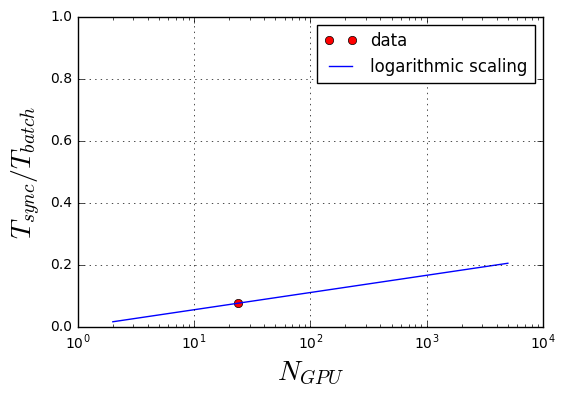

In [26]:
#logarithmic scaling of communication work!
# plt.semilogx(node_counts,communication_work/relative_array(np.log(node_counts)),'ro')
# plt.semilogx(fictitious_node_counts,communication_work_extended/relative_array(np.log(fictitious_node_counts)),'-')
plt.semilogx(node_counts,communication_work,'ro',label='data')
plt.semilogx(fictitious_node_counts,communication_work_extended,'-',label="logarithmic scaling")
#plt.semilogx(fictitious_node_counts,communication_work_extended_titan,'-',label="logarithmic scaling 2")
plt.grid()
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"$T_{sync}/T_{batch}$",size=20)
plt.ylim([0,1])
plt.legend(loc="best")

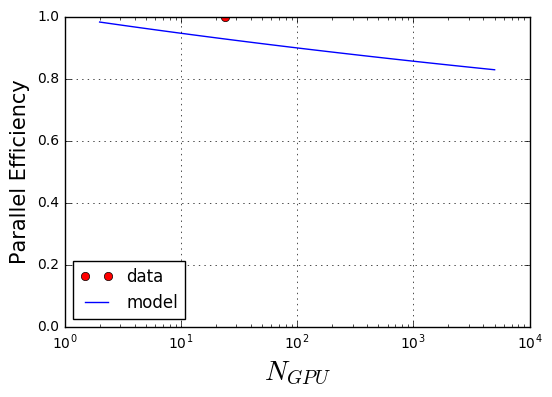

In [27]:
plt.semilogx(node_counts,scaled_execution_times[0]/scaled_execution_times,'ro',label="data")
plt.semilogx(fictitious_node_counts,scaled_execution_times[0]/scaled_modeled_execution_times,'-',label="model")
plt.ylim([0,1])
plt.grid()
plt.xlabel(r"$N_{GPU}$",size=20)
plt.ylabel(r"Parallel Efficiency",size=15)
plt.legend(loc="best")

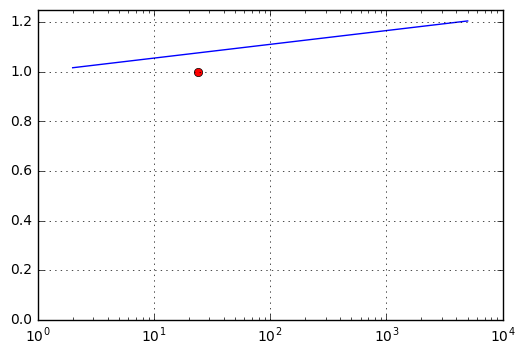

In [28]:
plt.semilogx(node_counts,scaled_execution_times/scaled_execution_times[0],'ro')
plt.semilogx(fictitious_node_counts,scaled_modeled_execution_times/scaled_execution_times[0],'-')
plt.ylim(0)
plt.grid()